In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [2]:
import os
from PIL import Image
from pathlib import Path
import glob
import cv2
import itertools
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D ,GlobalAveragePooling2D ,MaxPooling2D , Input ,Flatten , Dense ,Dropout , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print("Done")

2025-08-22 10:32:19.742724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755858740.109426      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755858740.208821      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


In [3]:
dataset_path = Path("/kaggle/input/lgg-mri-segmentation")
image_size = 128

In [4]:
image_paths = []
mask_paths = []

for image_path in glob.glob(f"{dataset_path}/**/*.tif", recursive=True):
    if not image_path.endswith("_mask.tif"):  
        mask_path = image_path.replace(".tif", "_mask.tif")
        if os.path.isfile(mask_path): 
            image_paths.append(image_path)
            mask_paths.append(mask_path)
            
df = pd.DataFrame({"image": image_paths, "mask": mask_paths})
print(f"Count of images: {len(image_paths)}")
print(f"Count of masks: {len(mask_paths)}")


Count of images: 7858
Count of masks: 7858


In [5]:
images = []  
masks = []  

for img_path, mask_path in zip(df["image"], df["mask"]):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, (image_size, image_size))
    mask = cv2.resize(mask, (image_size, image_size))
    
    img = img / 255.0
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)  
    
    images.append(img)
    masks.append(mask)
    
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")


Images shape: (7858, 128, 128, 3)
Masks shape: (7858, 128, 128, 1)


In [6]:

X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.3, random_state=42)


In [7]:
def unet_model(input_size=(image_size, image_size, 3)):
    inputs = layers.Input(input_size)
    
    # Downsample(Encoder)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    
    # Upsample(Decoder)
    u4 = layers.UpSampling2D((2,2))(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)
    
    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c5)
    
    model = models.Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


2025-08-22 10:36:05.201561: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_8[0][0]  

 Total params: 471,553 (1.80 MB)

 Trainable params: 471,553 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callbacks = [
    ModelCheckpoint("best_model.h5", monitor='val_loss',save_best_only=True)
]

In [9]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20, callbacks=callbacks)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1190s 7s/step - accuracy: 0.9570 - loss: 0.1349 - val_accuracy: 0.9900 - val_loss: 0.0286
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1175s 7s/step - accuracy: 0.9913 - loss: 0.0256 - val_accuracy: 0.9917 - val_loss: 0.0239
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1165s 7s/step - accuracy: 0.9922 - loss: 0.0228 - val_accuracy: 0.9924 - val_loss: 0.0212
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1180s 7s/step - accuracy: 0.9927 - loss: 0.0206 - val_accuracy: 0.9927 - val_loss: 0.0194
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1236s 7s/step - accuracy: 0.9933 - loss: 0.0189 - val_accuracy: 0.9938 - val_loss: 0.0166
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1213s 7s/step - accuracy: 0.9938 - loss: 0.0165 - val_accuracy: 0.9935 - val_loss: 0.0154
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1206s 7s/step - accuracy: 0.9939 - loss: 0.0155 - val_accuracy: 0.9946 - val_loss: 0.0122
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1213s 7s/step - accuracy: 0.9940 - loss: 0.0149 - 

In [10]:
model.save("Brain_Tumor_Segmentation_UNet.keras")

In [11]:
from tensorflow.keras.models import load_model
loaded_model = load_model("Brain_Tumor_Segmentation_UNet.keras")
loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_8[0][0]  

 Total params: 943,108 (3.60 MB)

 Trainable params: 471,553 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 471,555 (1.80 MB)

In [12]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred > 0.5).astype(np.float32).flatten()  
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

loss, acc = model.evaluate(X_val, Y_val, verbose=0)
print(f"Val Loss: {loss:.4f}")
print(f"Val Accuracy: {acc:.4f}")


y_pred = model.predict(X_val, verbose=0)

dice = dice_coefficient(Y_val, y_pred)
print(f"Val Dice Coefficient: {dice:.4f}")


Val Loss: 0.0058
Val Accuracy: 0.9970
Val Dice Coefficient: 0.8915


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


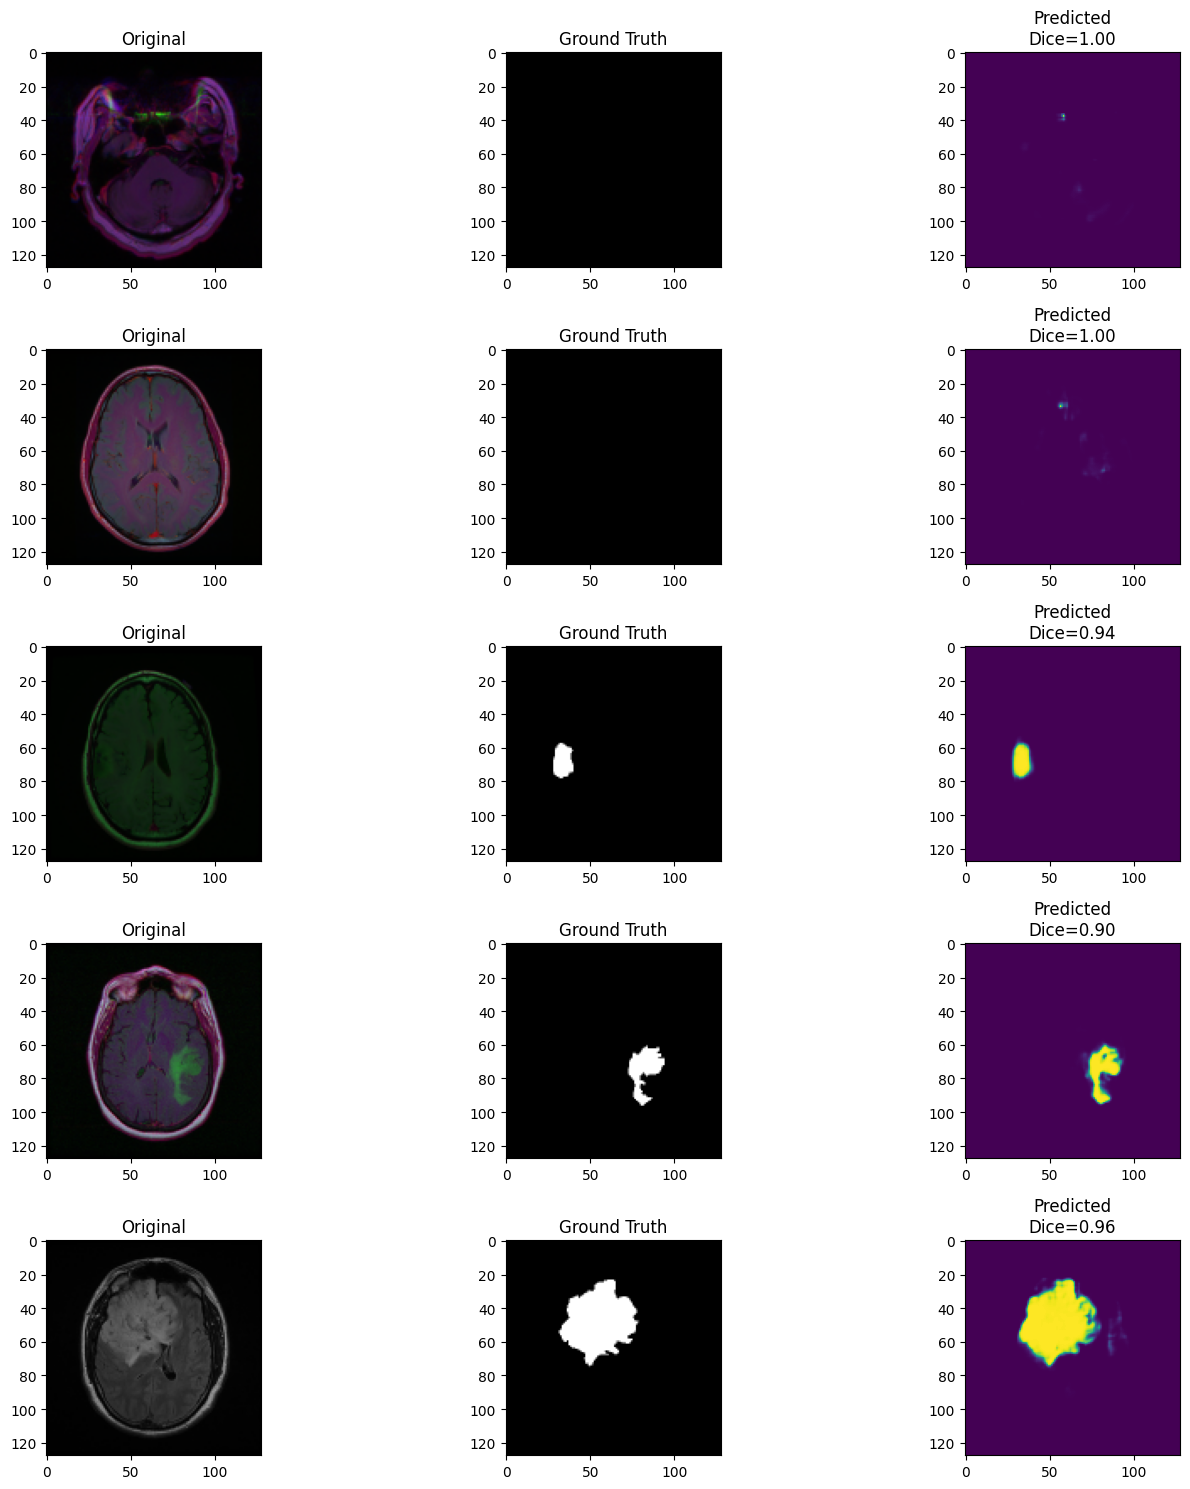

In [13]:
num_examples = 5
plt.figure(figsize=(15, num_examples*3))

for i in range(num_examples):
    idx = np.random.randint(0, len(X_val))  # صورة عشوائية
    img = X_val[idx]
    true_mask = Y_val[idx]
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

    dice = dice_coefficient(true_mask, pred_mask)

    plt.subplot(num_examples, 3, i*3 + 1)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(num_examples, 3, i*3 + 2)
    plt.imshow(true_mask[:,:,0], cmap="gray")
    plt.title("Ground Truth")

    plt.subplot(num_examples, 3, i*3 + 3)
    plt.imshow(pred_mask[:,:,0], cmap="viridis")
    plt.title(f"Predicted\nDice={dice:.2f}")

plt.tight_layout()
plt.show()


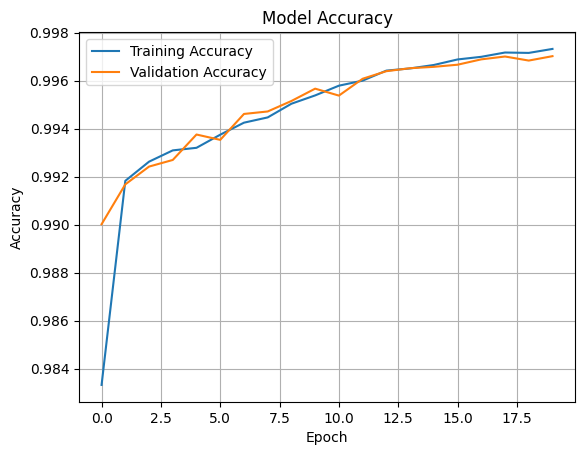

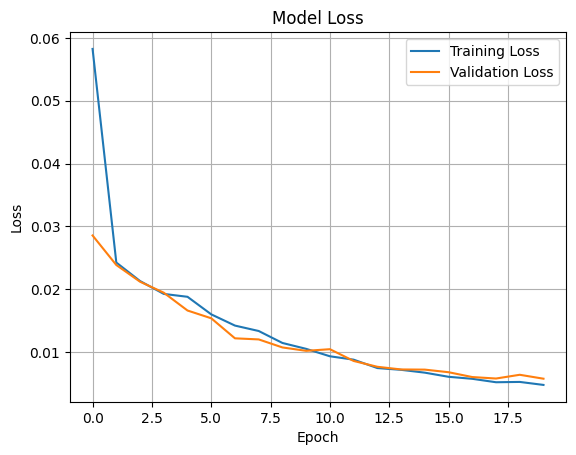

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()